# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, imputation_attack, whitebox_neuron_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict_list = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in np.arange(-0.9, 0.05, 0.05)[:].tolist()]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

[0, 1]
{0: {(0, 1): 11875, (0, 0): 624, (1, 1): 625, (1, 0): 11876}, 1: {(0, 1): 11875, (0, 0): 624, (1, 1): 625, (1, 0): 11876}}


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


[0, 1]
{0: {(0, 1): 11562, (0, 0): 937, (1, 1): 938, (1, 0): 11563}, 1: {(0, 1): 11562, (0, 0): 937, (1, 1): 938, (1, 0): 11563}}


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


[0, 1]
{0: {(0, 1): 11249, (0, 0): 1250, (1, 1): 1251, (1, 0): 11250}, 1: {(0, 1): 11249, (0, 0): 1250, (1, 1): 1251, (1, 0): 11250}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


[0, 1]
{0: {(0, 1): 10937, (0, 0): 1562, (1, 1): 1563, (1, 0): 10938}, 1: {(0, 1): 10937, (0, 0): 1562, (1, 1): 1563, (1, 0): 10938}}


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


[0, 1]
{0: {(0, 1): 10624, (0, 0): 1875, (1, 1): 1876, (1, 0): 10625}, 1: {(0, 1): 10624, (0, 0): 1875, (1, 1): 1876, (1, 0): 10625}}


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[0, 1]
{0: {(0, 1): 10312, (0, 0): 2187, (1, 1): 2188, (1, 0): 10313}, 1: {(0, 1): 10312, (0, 0): 2187, (1, 1): 2188, (1, 0): 10313}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


[0, 1]
{0: {(0, 1): 9999, (0, 0): 2500, (1, 1): 2501, (1, 0): 10000}, 1: {(0, 1): 9999, (0, 0): 2500, (1, 1): 2501, (1, 0): 10000}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[0, 1]
{0: {(0, 1): 9687, (0, 0): 2812, (1, 1): 2813, (1, 0): 9688}, 1: {(0, 1): 9687, (0, 0): 2812, (1, 1): 2813, (1, 0): 9688}}


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


[0, 1]
{0: {(0, 1): 9374, (0, 0): 3125, (1, 1): 3126, (1, 0): 9375}, 1: {(0, 1): 9374, (0, 0): 3125, (1, 1): 3126, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[0, 1]
{0: {(0, 1): 8749, (0, 0): 3750, (1, 1): 3751, (1, 0): 8750}, 1: {(0, 1): 8749, (0, 0): 3750, (1, 1): 3751, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 8124, (0, 0): 4375, (1, 1): 4376, (1, 0): 8125}, 1: {(0, 1): 8124, (0, 0): 4375, (1, 1): 4376, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 7499, (0, 0): 5000, (1, 1): 5001, (1, 0): 7500}, 1: {(0, 1): 7499, (0, 0): 5000, (1, 1): 5001, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[0, 1]
{0: {(0, 1): 7187, (0, 0): 5312, (1, 1): 5313, (1, 0): 7188}, 1: {(0, 1): 7187, (0, 0): 5312, (1, 1): 5313, (1, 0): 7188}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 6874, (0, 0): 5625, (1, 1): 5626, (1, 0): 6875}, 1: {(0, 1): 6874, (0, 0): 5625, (1, 1): 5626, (1, 0): 6875}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[0, 1]
{0: {(0, 1): 6562, (0, 0): 5937, (1, 1): 5938, (1, 0): 6563}, 1: {(0, 1): 6562, (0, 0): 5937, (1, 1): 5938, (1, 0): 6563}}


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[0, 1]
{0: {(0, 1): 6249, (0, 0): 6250, (1, 1): 6251, (1, 0): 6250}, 1: {(0, 1): 6249, (0, 0): 6250, (1, 1): 6251, (1, 0): 6250}}


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


In [5]:
experiments_texas = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict_list = 
    {
            'correlation': 0,
            'subgroup_col_name': 'ETHNICITY',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})", name='Texas100', sensitive_column='SEX_CODE'
) for (i, j) in [(k, k) for k in np.arange(0, 0.95, 0.05)[:].tolist()]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

[0, 1]
{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}}


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


[0, 1]
{0: {(0, 1): 5937, (0, 0): 6562, (1, 1): 6563, (1, 0): 5938}, 1: {(0, 1): 5937, (0, 0): 6562, (1, 1): 6563, (1, 0): 5938}}


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


[0, 1]
{0: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


[0, 1]
{0: {(0, 1): 5312, (0, 0): 7187, (1, 1): 7188, (1, 0): 5313}, 1: {(0, 1): 5312, (0, 0): 7187, (1, 1): 7188, (1, 0): 5313}}


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


[0, 1]
{0: {(0, 1): 5000, (0, 0): 7500, (1, 1): 7500, (1, 0): 5000}, 1: {(0, 1): 5000, (0, 0): 7500, (1, 1): 7500, (1, 0): 5000}}


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


[0, 1]
{0: {(0, 1): 4687, (0, 0): 7812, (1, 1): 7813, (1, 0): 4688}, 1: {(0, 1): 4687, (0, 0): 7812, (1, 1): 7813, (1, 0): 4688}}


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


[0, 1]
{0: {(0, 1): 4375, (0, 0): 8125, (1, 1): 8125, (1, 0): 4375}, 1: {(0, 1): 4375, (0, 0): 8125, (1, 1): 8125, (1, 0): 4375}}


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


[0, 1]
{0: {(0, 1): 4062, (0, 0): 8437, (1, 1): 8438, (1, 0): 4063}, 1: {(0, 1): 4062, (0, 0): 8437, (1, 1): 8438, (1, 0): 4063}}


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


[0, 1]
{0: {(0, 1): 3750, (0, 0): 8750, (1, 1): 8750, (1, 0): 3750}, 1: {(0, 1): 3750, (0, 0): 8750, (1, 1): 8750, (1, 0): 3750}}


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


[0, 1]
{0: {(0, 1): 3437, (0, 0): 9062, (1, 1): 9063, (1, 0): 3438}, 1: {(0, 1): 3437, (0, 0): 9062, (1, 1): 9063, (1, 0): 3438}}


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


[0, 1]
{0: {(0, 1): 3125, (0, 0): 9375, (1, 1): 9375, (1, 0): 3125}, 1: {(0, 1): 3125, (0, 0): 9375, (1, 1): 9375, (1, 0): 3125}}


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


[0, 1]
{0: {(0, 1): 2812, (0, 0): 9687, (1, 1): 9688, (1, 0): 2813}, 1: {(0, 1): 2812, (0, 0): 9687, (1, 1): 9688, (1, 0): 2813}}


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


[0, 1]
{0: {(0, 1): 2499, (0, 0): 10000, (1, 1): 10001, (1, 0): 2500}, 1: {(0, 1): 2499, (0, 0): 10000, (1, 1): 10001, (1, 0): 2500}}


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


[0, 1]
{0: {(0, 1): 2187, (0, 0): 10312, (1, 1): 10313, (1, 0): 2188}, 1: {(0, 1): 2187, (0, 0): 10312, (1, 1): 10313, (1, 0): 2188}}


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


[0, 1]
{0: {(0, 1): 1874, (0, 0): 10625, (1, 1): 10626, (1, 0): 1875}, 1: {(0, 1): 1874, (0, 0): 10625, (1, 1): 10626, (1, 0): 1875}}


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


[0, 1]
{0: {(0, 1): 1562, (0, 0): 10937, (1, 1): 10938, (1, 0): 1563}, 1: {(0, 1): 1562, (0, 0): 10937, (1, 1): 10938, (1, 0): 1563}}


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


[0, 1]
{0: {(0, 1): 1249, (0, 0): 11250, (1, 1): 11251, (1, 0): 1250}, 1: {(0, 1): 1249, (0, 0): 11250, (1, 1): 11251, (1, 0): 1250}}


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


[0, 1]
{0: {(0, 1): 937, (0, 0): 11562, (1, 1): 11563, (1, 0): 938}, 1: {(0, 1): 937, (0, 0): 11562, (1, 1): 11563, (1, 0): 938}}


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


[0, 1]
{0: {(0, 1): 624, (0, 0): 11875, (1, 1): 11876, (1, 0): 625}, 1: {(0, 1): 624, (0, 0): 11875, (1, 1): 11876, (1, 0): 625}}


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


{0: {(0, 1): 6250, (0, 0): 6250, (1, 1): 6250, (1, 0): 6250}, 1: {(0, 1): 5625, (0, 0): 6875, (1, 1): 6875, (1, 0): 5625}}


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


In [7]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.9, -0.9RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.85, -0.85RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.7999999999999999, -0.7999999999999999RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.7499999999999999, -0.7499999999999999RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.6999999999999998, -0.6999999999999998RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_a

In [6]:
save_model = True

for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

NameError: name 'experiments_texas' is not defined

In [8]:
from sklearn.inspection import permutation_importance

In [14]:
n_samples=5000
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment)
    experiment.influence_comp_indices = experiment.X_test.sample(n=n_samples, replace=False).index
    experiment.permutation_importance = permutation_importance(experiment.clf, experiment.X_test.iloc[experiment.influence_comp_indices], experiment.ds.ds.y_enc.transform(experiment.y_te[experiment.influence_comp_indices]).toarray(),
                           n_repeats=30,
                           random_state=0)

Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.9, -0.9RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.85, -0.85RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.7999999999999999, -0.7999999999999999RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.7499999999999999, -0.7499999999999999RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.6999999999999998, -0.6999999999999998RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.6499999999999998, -0.6499999999999998RPAREN
Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5999999999999998, -0.5999999999

In [23]:
influences = []
correlations = []
attack_performances = []

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.influence = experiment.permutation_importance.importances_mean[35]
    influences.append(experiment.influence)
    experiment.correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    correlations.append(experiment.correlation)
    # print(experiment.influence, experiment.correlation)
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)  
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()
    experiment.CSMIA_performance = 100 * accuracy_score(experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices])
    attack_performances.append(experiment.CSMIA_performance)


Text(0, 0.5, 'Attack Performance')

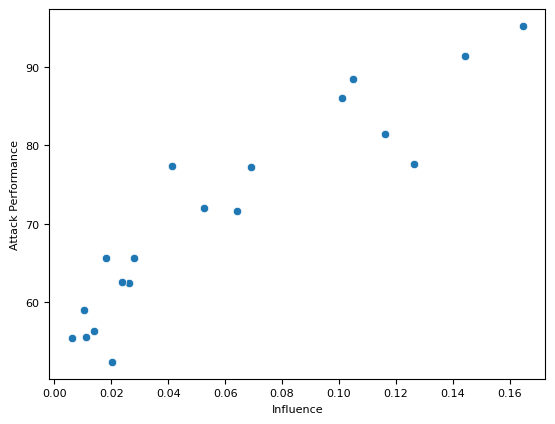

In [25]:
sns.scatterplot(x=influences, y=attack_performances)
plt.xlabel('Influence')
plt.ylabel('Attack Performance')

Text(0, 0.5, 'Attack Performance')

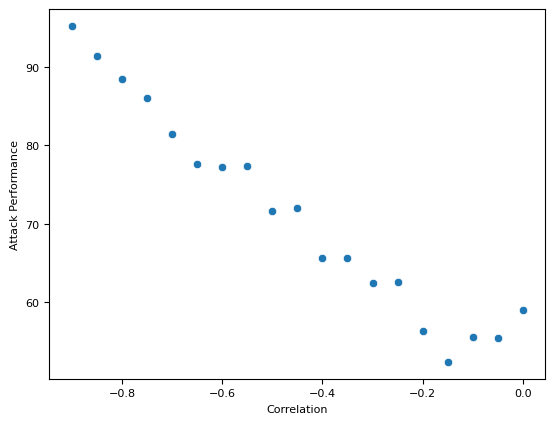

In [26]:
sns.scatterplot(x=correlations, y=attack_performances)
plt.xlabel('Correlation')
plt.ylabel('Attack Performance')

In [27]:
experiments.keys()

dict_keys(['corr_btn_sens_and_out_(-0.9, -0.9)', 'corr_btn_sens_and_out_(-0.85, -0.85)', 'corr_btn_sens_and_out_(-0.7999999999999999, -0.7999999999999999)', 'corr_btn_sens_and_out_(-0.7499999999999999, -0.7499999999999999)', 'corr_btn_sens_and_out_(-0.6999999999999998, -0.6999999999999998)', 'corr_btn_sens_and_out_(-0.6499999999999998, -0.6499999999999998)', 'corr_btn_sens_and_out_(-0.5999999999999998, -0.5999999999999998)', 'corr_btn_sens_and_out_(-0.5499999999999997, -0.5499999999999997)', 'corr_btn_sens_and_out_(-0.49999999999999967, -0.49999999999999967)', 'corr_btn_sens_and_out_(-0.4499999999999996, -0.4499999999999996)', 'corr_btn_sens_and_out_(-0.3999999999999996, -0.3999999999999996)', 'corr_btn_sens_and_out_(-0.34999999999999953, -0.34999999999999953)', 'corr_btn_sens_and_out_(-0.2999999999999995, -0.2999999999999995)', 'corr_btn_sens_and_out_(-0.24999999999999944, -0.24999999999999944)', 'corr_btn_sens_and_out_(-0.1999999999999994, -0.1999999999999994)', 'corr_btn_sens_and_ou

In [28]:
aux_df = experiments[f'corr_btn_sens_and_out_(-0.9, -0.9)'].ds.ds.df.copy()

In [38]:
wb_perfs = []
imp_perfs = []
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf, aux_df=aux_df)['accuracy']
    experiment.imputation_results = imputation_attack(experiment, aux_df_onehot=aux_df)['accuracy']
    wb_perfs.append(experiment.wb_neuron_results)
    imp_perfs.append(experiment.imputation_results)
    # print(experiment)
    # print(experiment.wb_neuron_results)
    # print(experiment.imputation_results)

Text(0, 0.5, 'NeurImp Attack Performance')

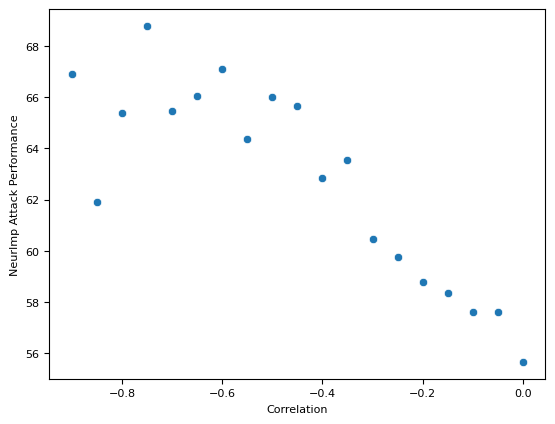

In [39]:
sns.scatterplot(x=correlations, y=wb_perfs)
plt.xlabel('Correlation')
plt.ylabel('NeurImp Attack Performance')

Text(0, 0.5, 'Imputation Attack Performance')

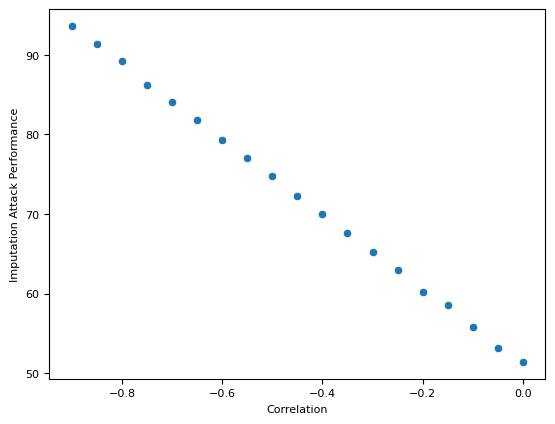

In [40]:
sns.scatterplot(x=correlations, y=imp_perfs)
plt.xlabel('Correlation')
plt.ylabel('Imputation Attack Performance')

In [31]:
experiments[f'corr_btn_sens_and_out_(-0.9, -0.9)'].wb_neuron_results

{'accuracy': 66.908,
 'precision': 66.4641271325076,
 'recall': 68.256,
 'fpr': 34.44,
 'f1': 67.34814697872677}

In [30]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment)
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf)
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [39]:
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment, subgroup_column='ETHNICITY')
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf, subgroup_column='ETHNICITY')
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [31]:
def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate
}

metrics = ['accuracy', 'precision', 'recall', 'fpr', 'f1']

In [32]:
performance_dict = {}
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [74]:
performance_dict_texas = {}
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict_texas[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict_texas[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict_texas[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [81]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

def plot_result(performance_dict, metric='accuracy'):
    attacks = ['CSMIA', 'LOMIA', 'imputation', 'wb_neuron']
    attack_names = attacks[:2] + ['Imputation', 'NeuronIMP']
    metric_name_dict = {'accuracy': 'Attack Accuracy', 'f1': 'F1 Score'}
    performance_dict_metric = {corr: {f'{attack}_results': performance_dict[corr][f'{attack}_results'][metric] for attack in attacks} for corr in performance_dict}

    df = pd.DataFrame.from_dict(performance_dict_metric, orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}_results'], label=attack_names[i], marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)

    x_ticks = np.arange(df.index.min(), df.index.max() + 0., 0.15).round(2).tolist()
    plt.xticks(x_ticks)
    plt.legend()
    plt.xlabel('Correlation')
    plt.ylabel(metric_name_dict[metric])
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    # plt.plot(df.index, df['LOMIA_attack_accuracy'], label='LOMIA', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))
    # plt.plot(df.index, df['imputation_attack_accuracy'], label='Imputation', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))

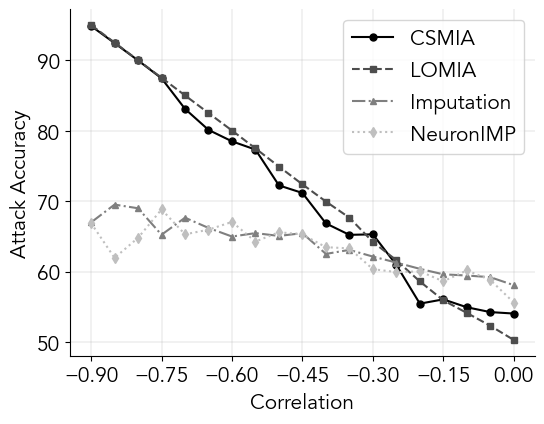

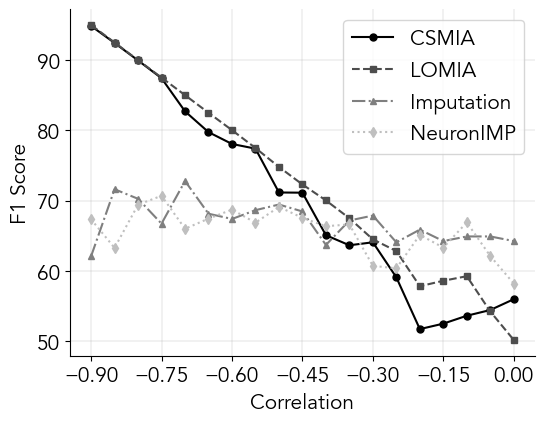

In [82]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict, metric=metric)

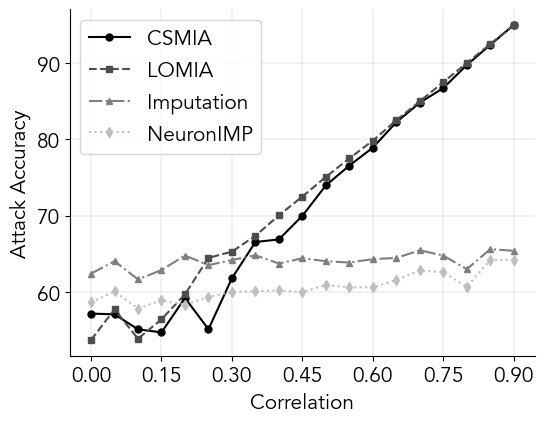

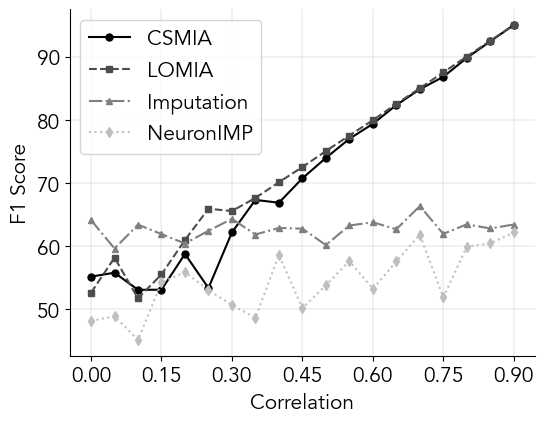

In [83]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict_texas, metric=metric)